<a href="https://colab.research.google.com/github/Slev1200/Data-Analysis-Projects/blob/main/FinalProject_FrosTea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports all the packages that will be used throughout this project
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import tweepy
import json
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
import numpy as np
from datetime import datetime
from collections import defaultdict
import math

# SEARCHTWEETS
!pip install searchtweets
from searchtweets import ResultStream
from searchtweets import gen_rule_payload
from searchtweets import load_credentials
from searchtweets import ResultStream

# JSON
import json

# YAML
import yaml

#NLTK
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer # SnowballStemmer

#GENSIM
import gensim
from gensim.models import Phrases #pip install --upgrade gensim

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 
# stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

#get tokens from each tweet
def text2tokens(text):
    #text = text.lower()
    text = re.sub(r"http.+|@\w+|#\w+|rt|&\w", " ", text.lower())
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 3]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

df_training=pd.read_csv("training.csv")
df_training["tokens"]=df_training.text.apply(text2tokens)

df_testing=pd.read_csv("testing.csv")
df_testing["tokens"]=df_testing.text.apply(text2tokens)
df_training.drop("Unnamed: 2", axis = 1, inplace=True)
df_training

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


FileNotFoundError: ignored

In [ ]:
""" Methods that are used within out project """

""" method that combines a list of strings into one separated with a |"""
def bar_join(str_list):
    if len(str_list) == 0:
        return ''
    else:
        return "|".join(str_list)

# loads the json file
def load_json(file_name):
    result=[]
    with open(file_name,'r') as fp:
        line=fp.readline()
        while line:
            tobj=json.loads(line)
            result.append({
                "created_at":tobj["created_at"],
                "id":tobj["id"],
                "text":tobj["text"],
                "favorite_count": tobj["favorite_count"],
                "retweet_count": tobj["retweet_count"],
                "user_id_str": tobj["user"]["id_str"],
                "user_name": tobj["user"]["name"],
                "user_screen_name": tobj["user"]["screen_name"],
                "user_location": tobj["user"]["location"],
                "user_description": tobj["user"]["description"],
                "user_friends_count": tobj["user"]["friends_count"],
                "user_followers_count": tobj["user"]["followers_count"],
                "hashtags":tobj["entities"]["hashtags"],
                "mentions":tobj["entities"]["user_mentions"],
                
            })
            line=fp.readline()
    return result   



In [ ]:
""" This cell decides who is crawling the tweets"""
class TweetRegistration:
    def __init__(self, user ):
        # R U L E 1:#############################################################################################
        self.search_words="immigration refugees OR undocumented illegal immigrant OR asylum deportation resettlement protected status"

        # only set user as "Sam" "Keegan" or "Nathan"
        if user == "Nathan":
            consumer_key_main = "GRQw6utNTUZ4F3e5wHpdXZgIs"
            consumer_secret_main = "S1hjm2Uh7JtpGvF0JPlx87ucxXCqSX6WnAMzWDMjzjVOubEtly"

            config = dict(
                search_tweets_api = dict(
                    account_type = 'premium', 
                    endpoint = 'https://api.twitter.com/1.1/tweets/search/fullarchive/test.json',
                    consumer_key = consumer_key_main,
                    consumer_secret = consumer_secret_main
                )
            )

        elif user == "Keegan":
            consumer_key_main = "6tuZr6DylfrnHvjClnu1xAPXy"
            consumer_secret_main = "SGxMSTEmHFyCo6gJjKbRxTPu7dZMUI8a4CTPpfOIdcbQDQ0gyU"

            config = dict(
                search_tweets_api = dict(
                    account_type = 'premium',
                    endpoint = 'https://api.twitter.com/1.1/tweets/search/fullarchive/testFullArchive.json',
                    consumer_key = consumer_key_main,
                    consumer_secret = consumer_secret_main
                )
            )    

        elif user == "Sam": 
            consumer_key_main = "ofuwmhm5ULSjR525bYjk1Us5o"
            consumer_secret_main = "N1PHkpUaUBt90vmRQBxUQIittyoPIL7WqZ3YE8TxhDBpxVvKKc"

            config = dict(
                search_tweets_api = dict(
                    account_type = 'premium',
                    endpoint = 'https://api.twitter.com/1.1/tweets/search/fullarchive/PremiumSearch.json',
                    consumer_key = consumer_key_main,
                    consumer_secret = consumer_secret_main
                )
            )  

        with open('twitter_keys.yaml', 'w') as config_file:
            yaml.dump(config, config_file, default_flow_style=False)

        self.premium_search_args = load_credentials(
            "twitter_keys.yaml",
            yaml_key="search_tweets_api",
            env_overwrite=False
        )   


    """This function creates a json file that contains tweets from a singular day of the year"""
    def myfunc(self, to, file_name): #make sure to include .json at end of "file_name" parameter
        payload_words = self.search_words
        rule = gen_rule_payload(payload_words,
                              results_per_call=100, #replace with 100
                              from_date="2014-12-25 00:00",
                              to_date=to
                            )

        rs = ResultStream(rule_payload=rule,
                          max_results=100, #replace with 100
                          **self.premium_search_args)

        counter=0
        with open(file_name, 'w+', encoding='utf-8') as f:
            for tweet in rs.stream():
                #print(tweet.retweet_count)
                print(f"{counter}, {tweet['created_at']}")
                counter+=1
                json.dump(tweet, f)
                f.write('\n')
        print('done')



    """ Function that takes a list of dates and a file name to create a json and return a df with top 10 most retweeted
        tweets of the year"""
    def get_our_tweets_plz(self, date_collection_list):
        file_name = 'temp.json'
        rawData_df = pd.DataFrame()
        year_df = pd.DataFrame()

      # iterate through the list of days
        for day in date_collection_list:
            # create the json for the year and crawl for the tweets
            self.myfunc(day, file_name)

            # load the json
            day_df=load_json(file_name)

            #put into df so we can sort
            day_df=pd.DataFrame(day_df)

            # add the day's data to the rawdata
            rawData_df = pd.concat([rawData_df,day_df])

            #get top 10 tweets with the highest retweet count
            top_tweets=day_df.sort_values(by="retweet_count", ascending=False).iloc[:10]

            # add to the year's data frame
            year_df=pd.concat([year_df,top_tweets])

        # go through every row to fix the mentions and hashtags formatting
        for index, row in year_df.iterrows():
            hashtags = []
            mentions = []

            # add the hashtags and mentions to the empty list if they exist
            for d in row["hashtags"]:
                hashtags.append(d["text"])
            for d in row["mentions"]:
                mentions.append(d["screen_name"])

            # remove duplicates 
            hashtags = list(dict.fromkeys(hashtags))
            mentions = list(dict.fromkeys(mentions))

            # format the column so that the information is split with "|"
            year_df.loc[index, "mentions"] = bar_join(sorted(mentions))
            year_df.loc[index, "hashtags"] = bar_join(sorted(hashtags))

        return year_df, rawData_df

# Declaring an instance of TweetRegistration class

#myTweetReg = TweetRegistration("Keegan")
#myTweetReg = TweetRegistration("Nathan")
myTweetReg = TweetRegistration("Nathan")


Grabbing bearer token from OAUTH


In [ ]:
# This method grabs all the tweets for either the first half or second half of the year
def getDateCollectionForSpecifiedYear(year, half):
    dc = []
    if half == "first":
      months = [0,1,2,3,4,5]
    if half == "second":
      months = [6,7,8,9,10,11,12]

    for m in months:
      for d in range(4):
        date = d * 9 + 1
        if m < 9:
          data = year +"-0" + str(m + 1) + "-" + str(date) + " 23:59"
        else:
          data = year + "-" + str(m) + "-" + str(date) + " 23:59"
        dc.append(data)

    return dc

dc2015a = getDateCollectionForSpecifiedYear("2015", "first")
dc2015b = getDateCollectionForSpecifiedYear("2015", "second")
dc2016a = getDateCollectionForSpecifiedYear("2016", "first")
dc2016b = getDateCollectionForSpecifiedYear("2016", "second")
dc2017a = getDateCollectionForSpecifiedYear("2017", "first")
dc2017b = getDateCollectionForSpecifiedYear("2017", "second")
dc2018a = getDateCollectionForSpecifiedYear("2018", "first")
dc2018b = getDateCollectionForSpecifiedYear("2018", "second")
dc2019a = getDateCollectionForSpecifiedYear("2019", "first")
dc2019b = getDateCollectionForSpecifiedYear("2019", "second")
dc2020a = getDateCollectionForSpecifiedYear("2020", "first")
dc2020b = getDateCollectionForSpecifiedYear("2020", "second")

In [ ]:
data=myTweetReg.get_our_tweets_plz(dc2015a)
data[0].to_csv("2015a.csv", index=False)
data[1].to_csv("rawData2015a.csv", index=False)

In [ ]:
data = myTweetReg.get_our_tweets_plz(dc2015b)
data[0].to_csv("2015b.csv", index=False)
data[1].to_csv("rawData2015b.csv", index=False)

In [ ]:
data=myTweetReg.get_our_tweets_plz(dc2016a)
data[0].to_csv("2016a.csv", index=False)
data[1].to_csv("rawData2016a.csv", index=False)

In [ ]:
data = myTweetReg.get_our_tweets_plz(dc2016b)
data[0].to_csv("2016b.csv", index=False)
data[1].to_csv("rawData2016b.csv", index=False)

In [ ]:
data = myTweetReg.get_our_tweets_plz(dc2017a)
data[0].to_csv("2017a.csv", index=False)
data[1].to_csv("rawData2017a.csv", index=False)

In [ ]:
data = myTweetReg.get_our_tweets_plz(dc2017b)
data[0].to_csv("2017b.csv", index=False)
data[1].to_csv("rawData2017b.csv", index=False)

In [ ]:
data = myTweetReg.get_our_tweets_plz(dc2018a)
data[0].to_csv("2018a.csv", index=False)
data[1].to_csv("rawData2018a.csv", index=False)

In [ ]:
data = myTweetReg.get_our_tweets_plz(dc2018b)
data[0].to_csv("2018b.csv", index=False)
data[1].to_csv("rawData2018b.csv", index=False)

In [ ]:
data = myTweetReg.get_our_tweets_plz(dc2019a)
data[0].to_csv("2019a.csv", index=False)
data[1].to_csv("rawData2019a.csv", index=False)

In [ ]:
data = myTweetReg.get_our_tweets_plz(dc2019b)
data[0].to_csv("2019b.csv", index=False)
data[1].to_csv("rawData2019b.csv", index=False)

In [ ]:
data = myTweetReg.get_our_tweets_plz(dc2020a)
data[0].to_csv("2020a.csv", index=False)
data[1].to_csv("rawData2020a.csv", index=False)

In [ ]:
data = myTweetReg.get_our_tweets_plz(dc2020b)
data[0].to_csv("2020b.csv", index=False)
data[1].to_csv("rawData2020b.csv", index=False)

In [ ]:
df_dataAll = pd.DataFrame()
df_rawAll = pd.DataFrame()

# Combines two similar CSVs into one CSV (e.g. 2015a.csv and 2015b.csv will become 2015.csv)
def readAndCombine(first,second,output):
    df1=pd.read_csv(first)
    df2=pd.read_csv(second)
    
    df_combine= pd.concat([df1,df2])
    
    df_combine.to_csv(output, index=False)
    
    return df_combine

year_df = readAndCombine("2015a.csv","2015b.csv","2015.csv")
rawYear_df = readAndCombine("rawData2015a.csv","rawData2015b.csv","raw2015.csv")    
df_dataAll = pd.concat([df_dataAll, year_df])
df_rawAll = pd.concat([df_rawAll, rawYear_df])

year_df = readAndCombine("2016a.csv","2016b.csv","2016.csv")
rawYear_df = readAndCombine("rawData2016a.csv","rawData2016b.csv","raw2016.csv")    
df_dataAll = pd.concat([df_dataAll, year_df])
df_rawAll = pd.concat([df_rawAll, rawYear_df])

year_df = readAndCombine("2017a.csv","2017b.csv","2017.csv")
rawYear_df = readAndCombine("rawData2017a.csv","rawData2017b.csv","raw2017.csv")    
df_dataAll = pd.concat([df_dataAll, year_df])
df_rawAll = pd.concat([df_rawAll, rawYear_df])

year_df = readAndCombine("2018a.csv","2018b.csv","2018.csv")
rawYear_df = readAndCombine("rawData2018a.csv","rawData2018b.csv","raw2018.csv")    
df_dataAll = pd.concat([df_dataAll, year_df])
df_rawAll = pd.concat([df_rawAll, rawYear_df])

year_df = readAndCombine("2019a.csv","2019b.csv","2019.csv")
rawYear_df = readAndCombine("rawData2019a.csv","rawData2019b.csv","raw2019.csv")    
df_dataAll = pd.concat([df_dataAll, year_df])
df_rawAll = pd.concat([df_rawAll, rawYear_df])

year_df = readAndCombine("2020a.csv","2020b.csv","2020.csv")
rawYear_df = readAndCombine("rawData2020a.csv","rawData2020b.csv","raw2020.csv")    
df_dataAll = pd.concat([df_dataAll, year_df])
df_rawAll = pd.concat([df_rawAll, rawYear_df])

df_dataAll.to_csv("data.csv", index=False)
df_rawAll.to_csv("rawData.csv", index=False)

df_dataAll

FileNotFoundError: ignored

In [ ]:
# Reads in all of our data from CSV files
df_main = pd.read_csv("data.csv")
df_2015 = pd.read_csv("2015.csv")
df_2016 = pd.read_csv("2016.csv")
df_2017 = pd.read_csv("2017.csv")
df_2018 = pd.read_csv("2018.csv")
df_2019 = pd.read_csv("2019.csv")
df_2020 = pd.read_csv("2020.csv")

# #replaces NaN with empty string
df_main[['hashtags', 'mentions', 'text']] = df_main[['hashtags', 'mentions', 'text']].fillna('')
df_2015[['hashtags', 'mentions', 'text']] = df_2015[['hashtags', 'mentions', 'text']].fillna('')
df_2016[['hashtags', 'mentions', 'text']] = df_2016[['hashtags', 'mentions', 'text']].fillna('')
df_2017[['hashtags', 'mentions', 'text']] = df_2017[['hashtags', 'mentions', 'text']].fillna('')
df_2018[['hashtags', 'mentions', 'text']] = df_2018[['hashtags', 'mentions', 'text']].fillna('')
df_2019[['hashtags', 'mentions', 'text']] = df_2019[['hashtags', 'mentions', 'text']].fillna('') 
df_2020[['hashtags', 'mentions', 'text']] = df_2020[['hashtags', 'mentions', 'text']].fillna('')
df_main

,created_at,id,text,favorite_count,retweet_count,user_id_str,user_name,user_screen_name,user_location,user_description,user_friends_count,user_followers_count,hashtags,mentions
0,Thu Jan 01 15:57:31 +0000 2015,550682238757523456,"NEW | 1,063 Syrian refugees resettled in Canad...",3.0,5.0,7.418697e+07,CBC Politics,CBCPolitics,"Ottawa, CANADA",The CBC's Parliamentary Bureau on Twitter (pho...,303.0,223281.0,,
1,Thu Jan 01 14:57:15 +0000 2015,550667072225542146,"Amarillo,TX: Unbelievably frank description of...",1.0,4.0,1.209148e+09,Ann Corcoran 🇺🇸,RefugeeWatcher,Maryland,Refugee Resettlement Watch is back! The speec...,1034.0,16527.0,,NoXenophobia
2,Wed Dec 31 15:59:20 +0000 2014,550320308323106817,#Palestinian refugees cannot return to their l...,0.0,3.0,1.864043e+09,Love 4 Palestine,WithPalestine,"Jerusalem, PALESTINE",The Palestinian cause is not for Palestinians ...,1909.0,1546.0,RestartTheRescue|refugees,Ed_Miliband
3,Wed Dec 31 14:31:43 +0000 2014,550298259973894145,Daniel Pipes: Sweden opting for suicide by #im...,1.0,2.0,1.209148e+09,Ann Corcoran 🇺🇸,RefugeeWatcher,Maryland,Refugee Resettlement Watch is back! The speec...,1034.0,16527.0,asylum|immigration|refugees,wordpressdotcom
4,Wed Dec 31 10:52:55 +0000 2014,550243197616545792,Letter writer: Refugee resettlement an affront...,3.0,2.0,1.209148e+09,Ann Corcoran 🇺🇸,RefugeeWatcher,Maryland,Refugee Resettlement Watch is back! The speec...,1034.0,16527.0,ImmigrationAction|Migration|greece|immigration...,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075,Sat Nov 28 23:00:58 +0000 2020,1332821817464066054,"Meet Anna Rodell, Editorial Director, The Immi...",0.0,1.0,3.271970e+09,Dan Salerno,Dan_Salerno_,"Michigan, USA",I'm a human being passionate about social just...,509.0,466.0,,TheImmCoalition
3076,Sat Nov 28 21:15:06 +0000 2020,1332795175744180224,Remi Weekes transposes the classic haunted hou...,8.0,1.0,2.399232e+07,frieze,frieze_magazine,London / Berlin / New York,frieze is the leading magazine of contemporary...,2360.0,276725.0,,
3077,Sat Nov 28 23:58:02 +0000 2020,1332836177062326273,RT @CBNNews: Joe Biden is promising open doors...,0.0,0.0,1.043946e+08,lUCI SZAFRA,LSZAFRA,Masonic paradise,Freemasonry forever. \nloving all others givin...,4325.0,737.0,,CBNNews
3078,Sat Nov 28 16:57:36 +0000 2020,1332730374515007488,RT @margaritaevna95: Modern day invasions are ...,0.0,0.0,3.839579e+07,Dead Man Sergius,DeadManSergius,Nowhere,Caminho só através das trevas.,211.0,38.0,,margaritaevna95


In [ ]:
#creates column for tokens in df
# df_main["tokens"]=df_main.text.apply(text2tokens)
# bigram=Phrases(df_main.tokens, min_count=5, delimiter = b' ')
# df_main["bigrams"]=[bigram[d] for d in df_main["tokens"]]

# Initializes tokens and bigrams for each dataframe (2015 - 2020)
def getBigrams(df):
  df["tokens"] = df.text.apply(text2tokens)
  bigram = Phrases(df.tokens, min_count=5, delimiter = b' ')
  df["bigrams"] = [bigram[d] for d in df["tokens"]]

getBigrams(df_main)
getBigrams(df_2015)
getBigrams(df_2016)
getBigrams(df_2017)
getBigrams(df_2018)
getBigrams(df_2019)
getBigrams(df_2020)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


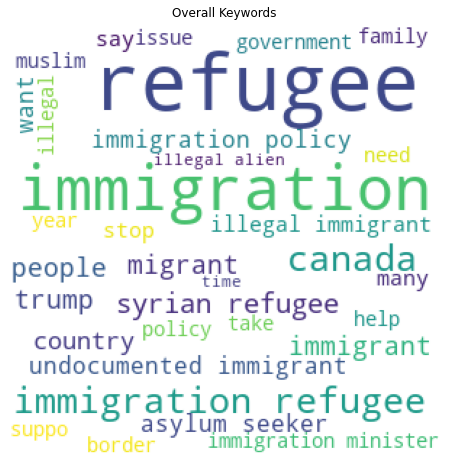

In [ ]:
# Word cloud of most popular keywords throughout all the years
words = []
#merge all lists of bigrams
for bigrams in df_main.bigrams:
    words.extend(bigrams)
text=" ".join(words)

# Creates a visualization of our overall keywords using a wordcloud
wordcloud = WordCloud(width = 300, height = 300, background_color = "white", min_font_size = 10).generate(text)
plt.figure(figsize = (8,8), facecolor = None)
plt.title("Overall Keywords")
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig("overall_pop_keywords")

In [ ]:
# Gets the total count of each location for every tweet except for tweets without locations

# Finds all the tweets that contain a location
loc_df = df_main[~df_main["user_location"].isin([""])]

# Group the tweets by its user location
group = loc_df.groupby(by = ["user_location"])
count_ser = group.user_location.count()
location_ser = group.user_location.first()

# Creates a dataframe with the user location and tweet count of each tweet 
location_df = pd.DataFrame(data = {"location": location_ser, "tweet_count": count_ser})

# Sorts the dataframe by the count and location in descending and ascending order
location_df = location_df.sort_values(by = ["tweet_count", "location"], ascending = [False, True])

# Saves the dataframe to a csv
location_df.to_csv("5yearTopLocation.csv", index = False)

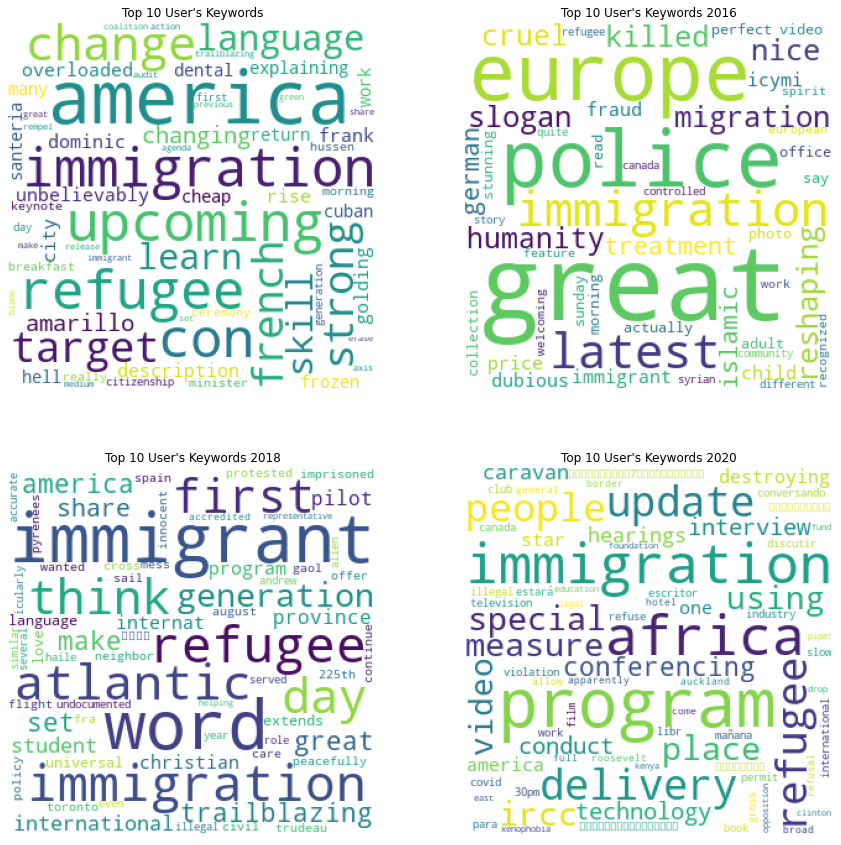

In [ ]:
# Creates a function that gets top 10 users tweeting abt immigration
def getTopUsers(df):
  
  # groups by 
  group = df.groupby(by = ["user_name"])
  count_ser = group.user_name.count()
  user_ser = group.user_name.first()
  location_ser = group.user_location.first()
  bigram_ser = group.bigrams.first()

  # Creates a dataframe with the user location and tweet count of each tweet 
  location_df = pd.DataFrame(data = {"users": user_ser, "tweet_count": count_ser, "location": location_ser, "bigrams": bigram_ser})

  # Sorts the dataframe and gets the top 10 users from it 
  new_df = location_df.sort_values(by = ["tweet_count", "location"], ascending = [False, True]).iloc[:10]
  return new_df

getTopUsers(df_main).to_csv("Top10Tweeters.csv", index = False)

# Gets main keywords and the amount of 
# those keywords per user and stores it in a dataframe
def wordCloud(df):
    
    words = []
    for bigrams in df.bigrams:
        words.extend(bigrams)
        
    counter = Counter(words)
    
    # Gets the top 100 most common words
    counter = counter.most_common(100)
    
    main_words = []
    main_count = []
    for w, f in counter:
        main_words.append(w)
        main_count.append(f)
        
    df_keywords = pd.DataFrame(data = {"keyword": main_words, "count": main_count})
    #new_df = new_df.sort_values(by = ["count"], ascending = [False])
    return df_keywords

top10_main = wordCloud(getTopUsers(df_main))
top10_2016 = wordCloud(getTopUsers(df_2016))
top10_2018 = wordCloud(getTopUsers(df_2018))
top10_2020 = wordCloud(getTopUsers(df_2020))

# Creates a wordcloud containing the appropriate keywords 
#representing the top 10 users that tweeted about immigration
def displayWordCloud(x, y, z, keywords, title):
    plt.subplot(x, y, z)
    text = " ".join(keywords)

    wordcloud = WordCloud(width = 300, height = 300, background_color = "white", min_font_size = 5).generate(text)
    plt.title(title)
    plt.axis('off')
    plt.imshow(wordcloud)

# Plotting the visualizations
plt.figure(figsize = (15, 15))
displayWordCloud(2, 2, 1, top10_main["keyword"], "Top 10 User's Keywords")
displayWordCloud(2, 2, 2, top10_2016["keyword"], "Top 10 User's Keywords 2016")
displayWordCloud(2, 2, 3, top10_2018["keyword"], "Top 10 User's Keywords 2018")
displayWordCloud(2, 2, 4, top10_2020["keyword"], "Top 10 User's Keywords 2020")
plt.tight_layout
plt.savefig("top10UserKeywords.png")
# Saves the dataframe to a csv
# df3.to_csv("location-count.csv", index = False)

In [ ]:
#merges all lists of hashtags into all_hash
all_hash = []
for h_list in df_main.hashtags:
  if (len(h_list)>0):
    h_list=h_list.lower()
    h_list = h_list.split("|")
    all_hash.extend(h_list)

# Creates a counter which counts how many individual hashtags there are
counter=Counter(all_hash)
counter=counter.most_common(len(all_hash))

# token_dict=[]

# Gets the top 10 most popular hashtags
df_top_10_hashtags = pd.DataFrame(counter[:10])
df_top_10_hashtags.columns=["hashtags", "count"]
df_top_10_hashtags.to_csv("top_10_hashtags.csv", index = False)
df_top_10_hashtags

,hashtags,count
0,immigration,395
1,refugees,378
2,auspol,40
3,asylum,39
4,cdnimm,37
5,immigrants,37
6,trump,36
7,tcot,34
8,cdnpoli,33
9,migrants,32


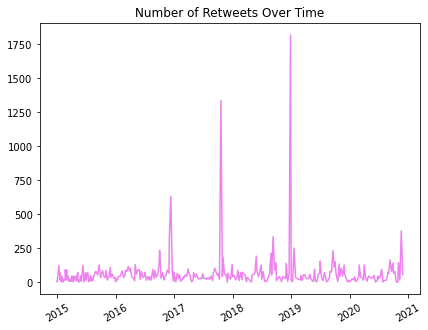

In [ ]:
date_list=[]

# go through all the rows and creates date
for index, row in df_main.iterrows():
    
    # get and append the date of the tweet
    date_of_tweet = datetime.strptime(row["created_at"], '%a %b %d %H:%M:%S +0000 %Y').date()
    date_list.append(date_of_tweet)

# add a new column to the data frame
df_main["created_at_date"] = date_list

dgroupby_date=df_main.groupby(by=["created_at_date"])

dates = list(dgroupby_date.created_at_date.first())
date_retweet_count = list(dgroupby_date.retweet_count.sum())

# plot the line graph of each group for the number of tweets per day.
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(dates, date_retweet_count, color = 'violet')
plt.xticks(rotation = 30)
plt.title("Number of Retweets Over Time")
plt.savefig("RetweetLineGraph.png") 

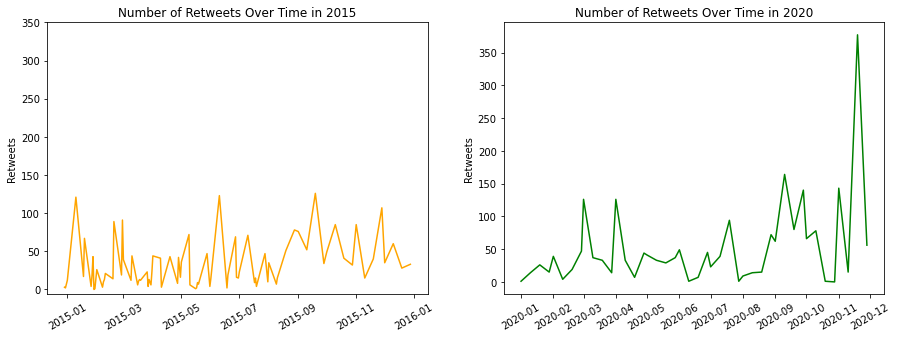

In [ ]:
"""Creates a line graph of retweets in 2020 """

date_list1=[]
date_list2=[]
# go through all the rows and create date
for index, row in df_2020.iterrows():
    
    # get and append the date of the tweet
    date_of_tweet = datetime.strptime(row["created_at"], '%a %b %d %H:%M:%S +0000 %Y').date()
    date_list1.append(date_of_tweet)

for index, row in df_2015.iterrows():
    
    # get and append the date of the tweet
    date_of_tweet = datetime.strptime(row["created_at"], '%a %b %d %H:%M:%S +0000 %Y').date()
    date_list2.append(date_of_tweet)

# add the new columns to the data frame
df_2020["created_at_date"] = date_list1
df_2015["created_at_date"] = date_list2

dgroupby_date1=df_2020.groupby(by=["created_at_date"])
dgroupby_date2=df_2015.groupby(by=["created_at_date"])

dates1 = np.array(list(dgroupby_date1.created_at_date.first()))
# dates2 = list(dgroupby_date2.created_at_date.first())

date_retweet_count1 = np.array(list(dgroupby_date1.retweet_count.sum()))
date_retweet_count2 = np.array(list(dgroupby_date2.retweet_count.sum()))

# plot the line graph of each group for the number of tweets per day.
plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.plot(dates1, date_retweet_count1, color = 'green')
plt.xticks(rotation = 30)
plt.ylabel("Retweets")
plt.title("Number of Retweets Over Time in 2020")


plt.subplot(1,2,1)
plt.plot(dates2, date_retweet_count2, color = 'orange')

plt.xticks(rotation = 30)
ytick = np.arange(0, 400, 50)
plt.yticks(ytick)
plt.ylabel("Retweets")
plt.title("Number of Retweets Over Time in 2015")
plt.savefig("RetweetLineGraphComparison.png")

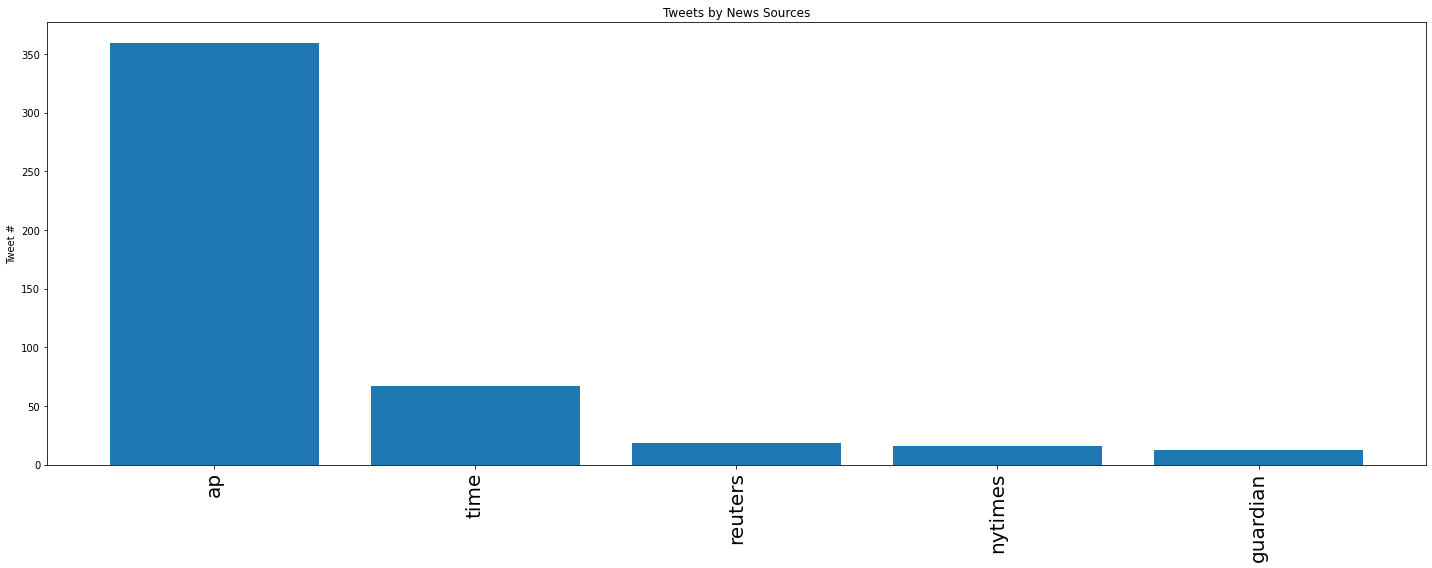

In [ ]:
# Creates a dict of all the news channels that could be mentioned in our data
channels={
    "CNN":0,
    "BBCBreaking":0,
    "nytimes":0,
    "TheEconomist":0,
    "WSJ":0,
    "Washingtonpost":0, 
    "cbcnews":0, 
    "independent":0, 
    "telegraph":0 ,
    "RT_com":0 ,
    "guardiannews":0, 
    "france23_en":0, 
    "cnbc" :0,
    "newsweek":0 ,
    "guardian": 0,
    "breakingnews":0 ,
    "huffpost":0, 
    "ndtv":0, 
    "xhnews":0,
    "nbcnews":0,
    "ap":0,
    "abc":0,
    "time":0,
    "reuters":0,
    "BBCworld":0,
    "Cnnbrk":0,
    "cnn":0,
    "Rollingstone":0,
    "foxnews":0,
    "usatoday":0,
    "msnbc_breaking":0,
    "telegraphnews":0,
    "nprpolitics":0,
    "usabreakingnews":0,
    "cnetnews":0,
    "yahoonews":0,
    "newyorkpost":0}

# Loops through our main data set and increases the value counter 
# of the specific news channel if we find that in our search 
for index, row in df_main.iterrows():
    for c in channels.keys():
      if c.lower() in (row["text"]) or c.lower() in (row["mentions"].lower()) or c.lower() in(row["hashtags"]):
        channels[c]+=1
channels

news=pd.DataFrame(list(channels.items()),columns = ['news_source','count']) 
news=news.sort_values(by = ["count","news_source"], ascending = [False, True]).iloc[:5]
news.to_csv("Top News Sources.csv", index = False)

# Creates a bar graph of the top 5 news sources tweeting about immigration
plt.figure(figsize = (20, 8))
top_10_values = list(news["count"])
top_10 = list(news["news_source"])
x_values = range(len(top_10))
width = .8

# graphs the values 
plt.bar([x for x in x_values], top_10_values, width)

# sets the labels and ticks of the graph
plt.xticks(x_values, top_10, fontsize = 20, rotation = 90)
plt.ylabel("Tweet #")
plt.title("Tweets by News Sources")
plt.tight_layout()
plt.savefig("Top News Sources")

In [ ]:
# Q1. Modify the KNN algorithm to
# classify positive, neutral, and
# negative tweets. Use training.csv to
# build the model (K=11). 

class KNNClassifier:
    def __init__(self, K=11):
        ### self means the K is a variable that only belongs to KNNClassifier class ###
        self.K=K
 
    def convert_to_vector(self,words):
        return [words.count(d) for d in self.dictionary]
    
    def cosine_sim(self,a,b):
        return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    
    def train(self, tokens_list, tags):
        
        ### Easier method to generate a dictionary ###
        dictionary = gensim.corpora.Dictionary(tokens_list)
        dictionary.filter_extremes(no_below=10, no_above=len(tokens_list)*0.6, keep_n=1000)
        self.dictionary=[v for k, v in dictionary.iteritems()]

        vectors=[self.convert_to_vector(tokens) for tokens in tokens_list]
        self.vectors_df=pd.DataFrame(data={
            "vector":vectors,
            "tag":tags
        })
        print(self.vectors_df.head(10))
    
    def predict(self, tokens):
        test_vector=self.convert_to_vector(tokens)
        distances=[self.cosine_sim(vector,test_vector) for vector in self.vectors_df.vector]
        self.vectors_df["distance"]=distances
        sorted_list=self.vectors_df.sort_values(by="distance", ascending=False).iloc[:self.K]
        pos_neg_neut_count=sorted_list.groupby(by="tag").tag.count()
        
        if "positive" and "negative" not in pos_neg_neut_count.index: #all docs are neutral
            return 0,1,0 #positive=0, neutral=1,negative =0
        elif "negative" and "neutral" not in pos_neg_neut_count.index:#all docs are positive
            return 1,0,0 #positive=1, neutral=0,negative =0
        elif "positive" and "neutral" not in pos_neg_neut_count.index:#all docs are negative
            return 0,0,1 #positive=0, neutral=0,negative =1
        
        elif "positive" not in pos_neg_neut_count.index:#all docs are negative or neutral
            return 0, pos_neg_neut_count["neutral"]/self.K, pos_neg_neut_count["negative"]/self.K
        
        elif "negative" not in pos_neg_neut_count.index:#all docs are negative or neutral
            return pos_neg_neut_count["positive"]/self.K, pos_neg_neut_count["neutral"]/self.K, 0
        
        elif "neutral" not in pos_neg_neut_count.index:#all docs are negative or neutral
            return pos_neg_neut_count["positive"]/self.K, 0, pos_neg_neut_count["negative"]/self.K
            
        else:
            return pos_neg_neut_count["positive"]/self.K, pos_neg_neut_count["neutral"]/self.K, pos_neg_neut_count["negative"]/self.K
        
        
knn_model=KNNClassifier(K=20)
knn_model.train(df_training.tokens, df_training.sentiment)

#test_text1="The flight was amazing, terrible service"
test_text2="bad service, so slow"
tokens=text2tokens(test_text2)
knn_model.predict(tokens)

predicts = []
neg = []
pos = []
neu = []
correct_counter=0
for index,row in df_testing.iterrows(): #iterate through each row in testing data
    #for each row, look at each percentage returned from prediction 
    p,nu,n=knn_model.predict(row["tokens"])
    neg.append(n)
    pos.append(p)
    neu.append(nu)
    if p>nu and p>n: 
        prediction="positive"
    if n>nu and n>p:
        prediction="negative"   
    if nu>n and nu>p:
        prediction="neutral" 
    predicts.append(prediction)
     
df_testing["prediction"]=predicts
df_testing["pos"]=pos
df_testing["neu"]=neu
df_testing["neg"]=neg
df_testing.to_csv("KNN_prediction.csv", index = False)




                                 vector       tag
0  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   neutral
1  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   neutral
2  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  negative
3  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  positive
4  [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  positive
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   neutral
6  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]   neutral
7  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  negative
8  [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  positive
9  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  positive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
# counts the amount of sentiment
count_pos=len(df_testing.loc[df_testing.prediction=="positive"])
count_neg=len(df_testing.loc[df_testing.prediction=="negative"])
count_neu=len(df_testing.loc[df_testing.prediction=="neutral"])

#creates a  dictionry
sentiment_count={
    "positive":count_pos,
    "negative":count_neg,
    "neutral":count_neu,
}
# create csv of the dictionairy
pd.DataFrame.from_dict(sentiment_count, orient='index').to_csv("count_sentiment.csv")


In [ ]:
#NAIVE BAYES function to predict whether a tweet is pos/neg/neu

class NaiveBayesClassifier:
    def __init__(self, k = 0.5):
        self.k = k  # smoothing factor
        self.token_pos_counts = defaultdict(int) # Number of pos docs countaining keywords
        self.token_neg_counts = defaultdict(int) # Number of neg docs countaining keywords
        self.token_neu_counts = defaultdict(int) # Number of neutral docs countaining keywords

        self.pos_count = self.neg_count = self.neu_count=0 # Number of pos docs,number of neg docs, and number of neu docs
    
    def train(self, tokens_list, tags):
        
        ### Easier method to generate a dictionary ###
        dictionary = gensim.corpora.Dictionary(tokens_list)
        dictionary.filter_extremes(no_below=10, no_above=len(tokens_list)*0.6, keep_n=1000)
        word_dict=[v for k, v in dictionary.iteritems()]
        self.dictionary=word_dict
        
        self.vectors_df=pd.DataFrame(data={
            "tokens":tokens_list,
            "tag":tags
        })
        
        pos_df=self.vectors_df.loc[self.vectors_df.tag=="positive"]
        neg_df=self.vectors_df.loc[self.vectors_df.tag=="negative"]
        neu_df=self.vectors_df.loc[self.vectors_df.tag=="neutral"]

        self.pos_count=len(pos_df)
        self.neg_count=len(neg_df)
        self.neu_count=len(neu_df)
        
        for index, row in self.vectors_df.iterrows():
            for keyword in word_dict:
                if keyword in row["tokens"]:
                    if row["tag"]=="positive":
                        self.token_pos_counts[keyword]+=1
                    elif row["tag"]=="neutral":
                        self.token_neu_counts[keyword]+=1
                    else:
                        self.token_neg_counts[keyword]+=1
        #print(self.token_pos_counts)

    def probabilities(self, token):
        pos=self.token_pos_counts[token]
        neg=self.token_neg_counts[token]
        neu=self.token_neu_counts[token]
        
        p_token_pos=(pos+self.k)/(self.pos_count+2*self.k)
        p_token_neg=(neg+self.k)/(self.neg_count+2*self.k)
        p_token_neu=(neu+self.k)/(self.neu_count+2*self.k)
        
        return p_token_pos,p_token_neg,p_token_neu
    
    def predict(self, tokens):
        log_prob_if_pos=log_prob_if_neg=log_prob_if_neu=0
        
        for token in self.dictionary:
            p_if_pos,p_if_neg,p_if_neu=self.probabilities(token)
            # Given *token* appears in the document,
            # add the log probability of seeing it;
            if token in tokens: 
            # (POS|token =1 )--> given token is in doc, what is prob that it is pos?, 
            # (NEG|token =1 )--> given token is in doc, what is prob that it is neg?
            # (NEU|token =1 )--> given token is in doc, what is prob that it is neu?
                log_prob_if_pos+=math.log(p_if_pos)
                log_prob_if_neg+=math.log(p_if_neg)
                log_prob_if_neu+=math.log(p_if_neu)
            # Given *token* does NOT appear in the document,
            # add the log probability of seeing it;
            # which is log(1 - probability of seeing it)
            else: 
            # (POS|token =0) --> given token is NOT in doc, what is prob that it is pos?, 
            # (NEG|token =0 )--> given token is NOT in doc, what is prob that it is neg?
            # (NEU|token =0 )--> given token is NOT in doc, what is prob that it is neu?
                log_prob_if_pos+=math.log(1-p_if_pos)
                log_prob_if_neg+=math.log(1-p_if_neg)
                log_prob_if_neu+=math.log(1-p_if_neu)
        
        pro_if_pos=math.exp(log_prob_if_pos) * (self.pos_count/(self.pos_count+self.neg_count+self.neu_count))
        pro_if_neg=math.exp(log_prob_if_neg) * (self.neg_count/(self.pos_count+self.neg_count+self.neu_count))
        pro_if_neu=math.exp(log_prob_if_neu) * (self.neu_count/(self.pos_count+self.neg_count+self.neu_count))
        
        return pro_if_pos/(pro_if_pos+pro_if_neg+pro_if_neu), pro_if_neg/(pro_if_pos+pro_if_neg+pro_if_neu),pro_if_neu/(pro_if_pos+pro_if_neg+pro_if_neu)
        
nb_model=NaiveBayesClassifier(k=0.5)
nb_model.train(df_training.tokens, df_training.sentiment)

# text_tokens = text2tokens("bad service, so slow")
# text_tokens = text2tokens("The movie is disgusting, very boring")
# nb_model.predict(text_tokens)


predicts=[]
neg=[]
pos=[]
neu=[]
correct_counter=0
for index,row in df_testing.iterrows(): #iterate through each row in testing data
    #for each row, look at each percentage returned from prediction 
    p,n,nu=nb_model.predict(row["tokens"])
    neg.append(n)
    pos.append(p)
    neu.append(nu)
    if p>nu and p>n: 
        prediction="positive"
    if n>nu and n>p:
        prediction="negative"   
    if nu>n and nu>p:
        prediction="neutral" 
    predicts.append(prediction)
    
        
#print(correct_counter)
df_testing["prediction"]=predicts
df_testing["pos"]=pos
df_testing["neu"]=neu
df_testing["neg"]=neg
# col=["tweet_id","airline_sentiment", "prediction", "pos", "neu", "neg"]
df_testing.to_csv("NB_prediction.csv", index = False)
#df_testing


In [ ]:
dem_keywords=["liberal","left-leaning","progressive","prochoice","universal healthcare","Obamacare","Obama","Alexandria Ocasio-Cortez", "Ilhan Omar", "Ayanna Pressley","Ayanna Pressley","Rashida Tlaib","TERRI A. SEWELL","TOM O'HALLERAN","RAUL M. GRIJALVA","JERRY MCNERNEY","LISA BLUNT ROCHESTER","DNC", "TheDemocrats", "Biden", "JoeBiden", "Our best days still lie ahead", "No Malarkey!"]
rep_keywords=["conservative","right-leaning","prolife","Mitch McConnell","Kevin McCarthy","Steve Scalise","Liz Cheney","Tom Emmer","Jason Smith","Gary Palmer","Mark Walker","Mike Rogers","MAGA2020", "#NovemberElection" ,"GOP", "Trump", "POTUS", "realDonaldTrump", "Pence", "Mike_Pence", "VP", "Keep America Great"]


def get_party(text):
    p_list=[]
    #for each keyword in dem_keywords, check if it appears in user desciption
    for d in text:
        dem=False
        rep=False    
#         print(d+"\n")
#         print("------------")
        for w in dem_keywords:
            if w in d:
                dem=True
                break
        for w in rep_keywords:
            if w in d:
                rep=True
                break
       
        if dem==False and rep==False:
            p_list.append("None") 
        elif dem==True and rep==False:
            p_list.append("Democratic")
        elif dem==False and rep==True:
            p_list.append("Republican")
        else:
            p_list.append("Both")
    return p_list
        
df_main["party"]=get_party(df_main.text)
count_party = Counter(df_main["party"])

count_party_df = pd.DataFrame(data={"count_party":count_party.keys(), "count":count_party.values()})
count_party_df.to_csv("count parties.csv", index = False)

df_dem=df_main.loc[df_main.party == "Democratic"]
df_rep=df_main.loc[df_main.party == "Republican"]
df_both=df_main.loc[df_main.party == "Both"]
df_none=df_main.loc[df_main.party == "None"]

dem_hash=df_dem["hashtags"]
rep_hash=df_rep["hashtags"]
none_hash=df_none["hashtags"]
both_hash=df_both["hashtags"]
dem_hash


from scipy.stats import bernoulli
from scipy.stats import binom


n=500
p=len(rep_hash)/(len(dem_hash)+len(rep_hash))
b=binom.pmf(200,n,p)
# print("if 500 tweets were randomly selected, the probability that 200 of them are republican: " + str(b))

# • what is the probability that less than 50% of them are republican?
p_less_than_75=binom.cdf(375,n,p)
print("the probability that less than or equal to 75% of them are republicans: " + str(p_less_than_75))



the probability that less than or equal to 75% of them are republicans: 7.268689854130653e-09


use q3 to choose dem or rep

list of rep and list of dem hashtags

use p test to see if statistically different